In [ ]:
# 3 perpendicular gaussians:

data_means = torch.Tensor([
                    [-2.0, 0.0],
                    [0.0, -2.0],
                    [0.0, 2.0]
                    ])

data_covars = torch.Tensor([
                    [[0.3**2, 0],[0, 1]],
                    [[1, 0],[0, 0.3**2]],
                    [[1, 0],[0, 0.3**2]]
                    ]) 

sigma = torch.Tensor([[0.1, 0], [0, 1]]) 

def plot_data(X, title, save, epoch=False, npoints=20000, xlim=[-10,10], ylim=[-10,10], figsize=(5,5),cmap='jet'):
    x = X[:npoints,0].numpy()
    y = X[:npoints,1].numpy()
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    fig , ax = plt.subplots(1, 1, figsize=figsize)
    plt.scatter(x, y, s=2, c=z, alpha=0.75, cmap=cmap)
    if epoch: plt.text(4,-9, r'epoch {}'.format(epoch), fontsize=10, wrap=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    fig.tight_layout()
    plt.savefig(save)
    

def gaussian_mix(means=data_means, 
                covars=data_covars, 
                data_size=60000, 
                noise_covariance=torch.Tensor([[1, 0],[0, 1]]),
                dof=3,
                pointwise_noise=False,
                scale_factor=0.15):

    v = torch.distributions.MultivariateNormal(loc=data_means, covariance_matrix=data_covars).sample((data_size,)).reshape((-1, 2))
    idx = torch.randperm(v.shape[0])
    v = v[idx]
    sigma = torch.empty(v.shape[0], 4)
    noise = torch.empty(v.shape)

    for i in range(v.shape[0]): 
        
        if not pointwise_noise: cov = noise_covariance
        elif pointwise_noise=='radial': cov = radial_dependent_covariance(v[i], noise_covariance)
        elif pointwise_noise=='angular': cov = angle_dependent_covariance(v[i], noise_covariance)
        elif pointwise_noise=='mixed': cov = mixed_dependent_covariance(v[i], noise_covariance)
        elif pointwise_noise=='inverse_Wishart': cov = torch.tensor(invwishart.rvs(df=6, scale=noise_covariance, size=1).astype('float32'))
            
        sigma[i] = torch.reshape(cov, (1, 4))
        noise[i] = torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=cov).sample((1,))

    w = torch.zeros(v.shape[0], 6) # concat noise covariance 2x2 matrix to data -> 6=2+(2x2)
    w[:, :2] = v + noise
    w[:, 2:] = sigma

    return v, w

In [ ]:
from scipy import stats

v, w = gaussian_mix(data_size=10000, 
                    noise_covariance=sigma, 
                    dof=3,
                    pointwise_noise=False)

In [ ]:
plot_data(v, title=r'True $P(\mathbf{v})$', save= 'truth_data.pdf') 
plot_data(w, title=r'Smeared $P(\mathbf{w})$', save='smeared_data.pdf'

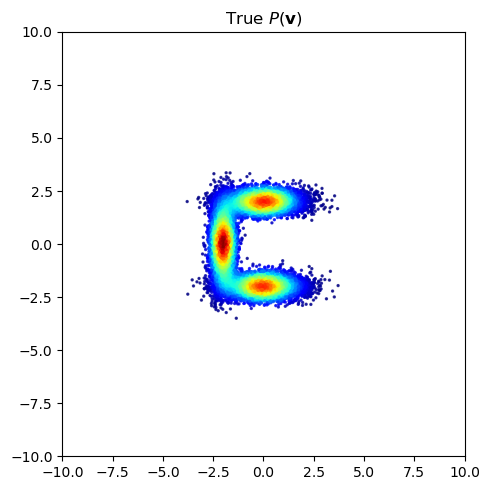

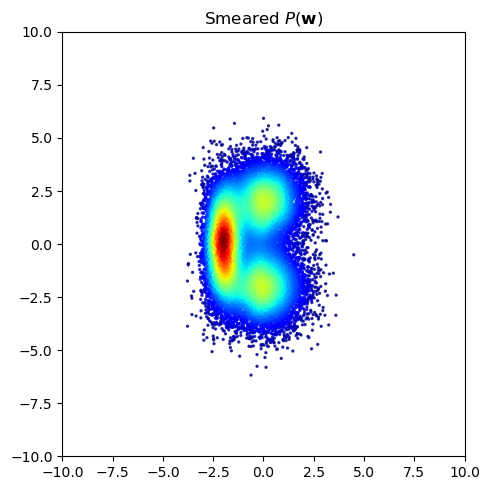